In [6]:
import os
import datetime as dt
import six
import numpy as np
import numpy.random as rd 
import h5py
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
# ------------------------------
# Lecture du fichier .h5 X_train
# ------------------------------
hdFileName = 'X_train.h5'
modeType   = 'r'
hf_train = h5py.File(hdFileName, modeType)

In [ ]:
# -------------------------------------------------------------
# Affichage des informations sur le contenu du fichier X_train
# -------------------------------------------------------------

print(hf_train,'\n')
print(hf_train.keys(),'\n')
hf_train.visit(lambda x: print(x, hf_train[x]))

In [596]:
# ------------------------------------------------------------------
# Lecture des dataset des dataframes pour les manipuler facilement
# ------------------------------------------------------------------
#electroencephalogrammes
eeg1 = hf_train['eeg_1']
eeg2 = hf_train['eeg_2']
eeg3 = hf_train['eeg_3']
eeg4 = hf_train['eeg_4']
eeg5 = hf_train['eeg_5']
eeg6 = hf_train['eeg_6']
eeg7 = hf_train['eeg_7']

#pouls
pulse = hf_train['pulse']

#des indices (why not)
index = hf_train['index']
index_absolute = hf_train['index_absolute']
index_window = hf_train['index_window']

#mouvement des yeux
x_mvt,y_mvt,z_mvt = hf_train['x'], hf_train['y'], hf_train['z']

In [597]:
# -------------------------------------------------------------
# Lecture du fichier .csv y_train (classes de stage de sommeil)
# -------------------------------------------------------------
sample_submission = pd.read_csv("sample_submission.csv")
y = pd.read_csv("y_train.csv").set_index('index')

In [ ]:
index_window[1027]

# Objectif et description des données

L'objectif de ce challenge est de réussir à prédire la phase de sommeil dans laquelle se trouve un sujet porteur du casque de mesure développé par Dreem. Les phases de sommeil sont définies comme suit :

- 0 Wake
- 1 NREM1 Sleep (light sleep 1)
- 2 NREM2 Sleep (light sleep 2)
- 3 NREM3 sleep (deep sleep)
- 4 REM sleep (paradoxical sleep)

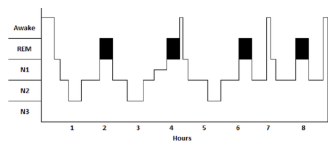

In [908]:
import matplotlib.image as mpimg
plt.figure(figsize=(20,10))
plt.imshow(mpimg.imread('Hypnogram-of-scored-human-sleep-staging.png'))
plt.axis("off")
plt.subplots_adjust(left=0.4, right=0.6, top=1, bottom=0,wspace=0)
plt.show()

Les données recueillies par le casque et mises à notre disposition sont les suivantes :

- 7 enregistrements EGG (3 mesures frontales, 4 mesures fronto-occipitales)
- Un enregistrement de pulsation cardiaque
- 3 enregistrements de mouvements des yeux, un sur chaque axe de l'espace

Dans la suite, nous allons proposer un modèle de classificateur permettant de prédire la phase de sommeil à l'aide de ces données, et définir des caractéristiques interessantes quant à l'étude de ces phases.

# Extraction de caractéristiques

## Features extraites des EEGs

### Prétraitement

En observant un échantillon de signaux EEGs, on constate que certains motifs sont caractéristiques de chacunes des phases de sommeil. Ceux-ci sont résumés sur la figure ci-dessous.

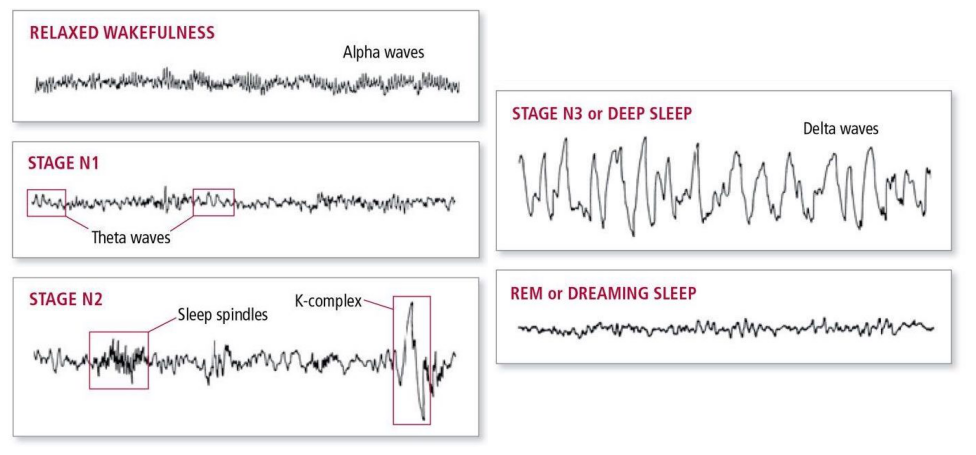

In [915]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(mpimg.imread('paterns1.jpg'))
ax[1].imshow(mpimg.imread('paterns2.jpg'))
ax[0].axis("off")
ax[1].axis("off")
plt.subplots_adjust(left=0.2, right=0.8, top=1, bottom=0,wspace=0)
plt.show()

Dans les enregistrements EEG fournis, on retrouve les caractéristiques décrites précedement. Cependant, on constate que les enregistrements sont également relativement bruités, et presentent des sauts qui pourraient être la résultante de mouvement du sujet lors de l'enregistrement.

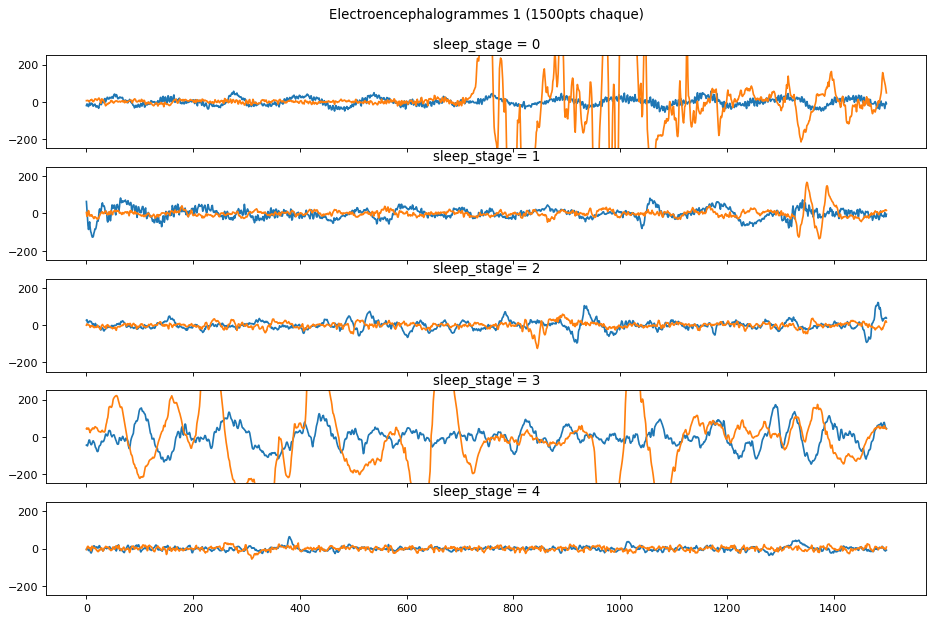

In [898]:
N=5
fig, axs = plt.subplots(N, sharex=True, figsize=(55,N*1.5))
fig.suptitle("Electroencephalogrammes 1 (1500pts chaque)")

for i in range(5):
    axs[i].set_title("sleep_stage = "+str(i))
    axs[i].set_ylim(-250,250)

list=[0,0,0,0,0]

while list!=[2,2,2,2,2]:
    indice = rd.randint(24688)
    sleep = y['sleep_stage'][indice]
    if sleep == 0 and list[0]<2:
        axs[0].plot(eeg1[indice])
        list[0]+=1
    elif sleep == 1 and list[1]<2:
        axs[1].plot(eeg1[indice])
        list[1]+=1
    elif sleep == 2 and list[2]<2:
        axs[2].plot(eeg1[indice])
        list[2]+=1
    elif sleep == 3 and list[3]<2:
        axs[3].plot(eeg1[indice])
        list[3]+=1
    elif sleep == 4 and list[4]<2:
        axs[4].plot(eeg1[indice])
        list[4]+=1

for ax in axs:
    ax.label_outer()
    
plt.subplots_adjust(left=0.4, right=0.6, top=0.9, bottom=0)

On peut donc sentir qu'une information sur la phase de sommeil se trouve dans la composition fréquentielle du signal ainsi que dans son énergie. Afin d'extraire des caractéristiques des signaux EEG qui pourraient ainsi être utiles, nous cherchons à calculer la puissance des signaux dans différentes bandes de fréquence. En nous appuyant sur les travaux de Khald Ali I. Aboalayon, Miad Faezipour, Wafaa S. Almuhammadi et Saeid Moslehpour, nous allons décomposer le signal selon les bandes de fréquences suivantes :

- Delta ($\delta$) : 0-4 Hz
- Theta ($\theta$) : 4-8 Hz
- Alpha ($\alpha$) : 8-13 Hz
- Beta ($\beta$) : 13-30 Hz
- Gamma ($\gamma$) : >30 Hz

Puis nous calculerons la puissance dans chacune de ces bandes. On utilise des filtres passe bas/haut/bande pour obtenir la réstriction du signal à ces bandes de fréquence. Les filtres utilisés sont des filtres Butterworth qui présentent l'avantage d'avoir un gain aussi constant que possible sur la bande passante. Sur la figure ci-dessous se trouvent deux exemples de EEG filtrés.

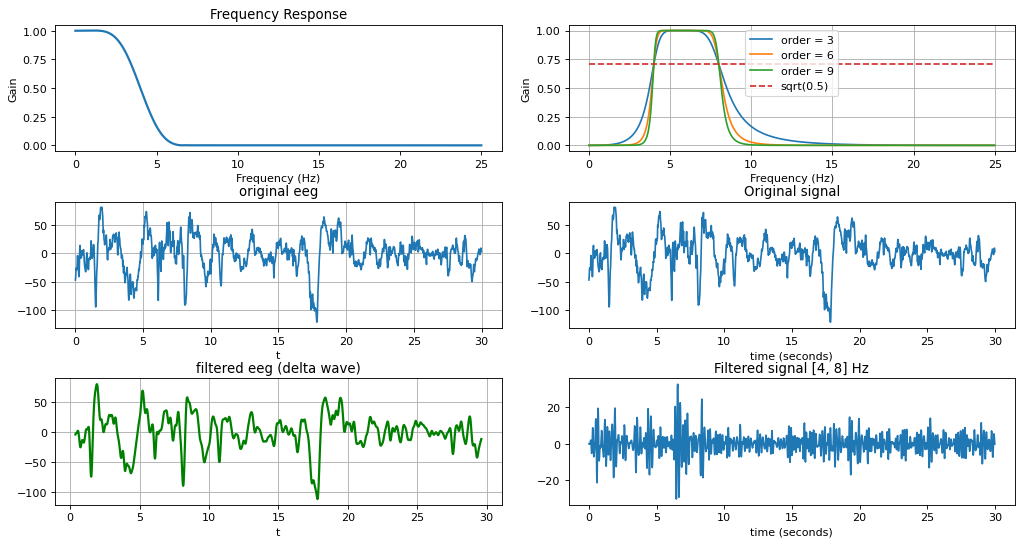

In [592]:
#@title Low Pass Filter (delta wave)

from scipy.signal import kaiserord, lfilter, firwin, freqz
#------------------------------------------------
# Create a signal for demonstration.
#------------------------------------------------

sample_rate = 50
nsamples = 1500
t = np.arange(nsamples) / sample_rate
x = eeg1[411]

#------------------------------------------------
# Create a FIR filter and apply it to x.
#------------------------------------------------

# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# Compute the oLrder and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 4

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

# Use lfilter to filter x with the FIR filter.
filtered_x = lfilter(taps, 1.0, x)

#------------------------------------------------
# Plot the magnitude response of the filter.
#------------------------------------------------

fig, ax = plt.subplots(3,2,figsize = (60,6))
#plt.figure(1, figsize = (12,2))
#plt.clf()
w, h = freqz(taps, worN=8000)
ax[0,0].plot((w/np.pi)*nyq_rate, np.absolute(h), linewidth=2)
ax[0,0].set_xlabel('Frequency (Hz)')
ax[0,0].set_ylabel('Gain')
ax[0,0].set_title('Frequency Response')
#ax[0].ylim(-0.05, 1.05)

#------------------------------------------------
# Plot the original and filtered signals.
#------------------------------------------------

# The phase delay of the filtered signal.
delay = 0.5 * (N-1) / sample_rate

# Plot the original signal.
#plt.figure(2, figsize = (12,2))
ax[1,0].plot(t, x)
ax[1,0].set_xlabel('t')
ax[1,0].grid(True)
ax[1,0].set_title("original eeg")

# Plot the filtered signal, shifted to compensate for the phase delay.
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
#plt.figure(3, figsize = (12,2))
ax[2,0].plot(t[N-1:]-delay, filtered_x[N-1:], '-g', linewidth=2)
ax[2,0].set_xlabel('t')
ax[2,0].grid(True)
ax[2,0].set_title("filtered eeg (delta wave)")


#@title Butterworth Band Pass filter (exemple for theta waves)

from scipy.signal import butter, lfilter, freqz, iirfilter

#------------------------------------------------
# Create a Band filter
#------------------------------------------------
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

#------------------------------------------------
# Apply filter to signal
#------------------------------------------------
fs = 50 #nb points par seconde
lowcut = 4
highcut = 8

T = 30.0 #30 seconds signal
nsamples = int(T * fs)
t = np.linspace(0, T, nsamples, endpoint=False)
x_plt = eeg1[411]
y_plt = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)


#------------------------------------------------
# Frequency response
#------------------------------------------------
#plt.figure(1, figsize = (6,3))
#plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=1500)
    ax[0,1].plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

ax[0,1].plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
          '--', label='sqrt(0.5)')
ax[0,1].set_xlabel('Frequency (Hz)')
ax[0,1].set_ylabel('Gain')
ax[0,1].grid(True)
ax[0,1].legend(loc='best')

#------------------------------------------------
# Plot the original and filtered signals.
#------------------------------------------------

#plt.figure(2, figsize=(12,2))
ax[1,1].plot(t, x_plt)
ax[1,1].set_title('Original signal')
ax[1,1].set_xlabel('time (seconds)')

#plt.figure(3, figsize=(12,2))
ax[2,1].plot(t, y_plt)
ax[2,1].set_title('Filtered signal ['+str(lowcut)+', '+str(highcut)+'] Hz')
ax[2,1].set_xlabel('time (seconds)')


plt.subplots_adjust(left=0.4, right=0.6, top=1, bottom=0,hspace=0.4,wspace=0.15)

### Calcul de l'énergie du signal dans les bandes spectrales

L'approche la plus simple est de calculer la densité spectrale de puissance du signal EEG en utilisant la méthode Fast Fourier Transform. Puis, pour chacune des bandes de fréquence $\delta,\theta,\alpha,\beta$ ($\gamma$ étant trop haute vis à vis de la fréquence d'échantillonnage 50Hz) on calcule l'énergie sur la bande de fréquence. Ci-dessous se trouve un EGG1 ainsi que sa transformée de densité de puissance. On obtient, avec les 7 EEGs, 28 features. Ci-dessous se trouve la densité spectrale de puissance d'un signal non filtré.

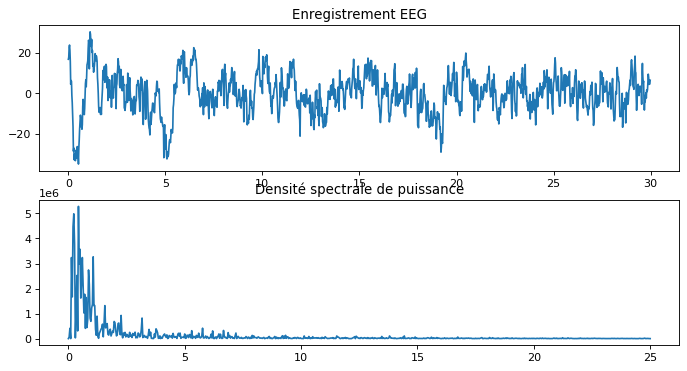

In [836]:
#@title Exemple signal densité spectrale
x = eeg1[rd.randint(24688)]

fs = 50
T = 30.0 #30 seconds signal
nsamples = int(T * fs)
t = np.linspace(0, T, nsamples, endpoint=False)

fig, ax = plt.subplots(2,1,figsize=(40,4))
ax[0].plot(t, x)
ax[0].set_title('Enregistrement EEG')
fourier_transform = np.fft.rfft(x)
abs_fourier_transform = np.abs(fourier_transform)
power_spectrum = np.square(abs_fourier_transform)
frequency = np.linspace(0, fs/2, len(power_spectrum))
ax[1].plot(frequency, power_spectrum)
ax[1].set_title('Densité spectrale de puissance')
plt.subplots_adjust(left=0.4, right=0.6, top=1, bottom=0)

Plusieurs méthodes existent pour calculer la densitée de puissance et l'énergie, à commencer par appliquer la formule suivante à la transformée de Fourier FFT :

$$E(f_{min},f_{max})=\sqrt{\sum_{f=f_{min}}^{f_{max}} FFT(f)^2}$$

D'autre méthodes existent, telles que celles proposées dans la librairie $\texttt{bandpower}$ et notamment les methodes 'weltch' et 'multitaper'. Celles-ci propose une variance plus faible dans le domaine fréquencielle. Après plusieurs essais, les meilleurs résultats ont été donnés avec la méthode 'multitaper'.

In [ ]:
#!pip install mne

In [162]:
#@title Definition de bandpower - code from https://raphaelvallat.com/bandpower.html

def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [164]:
#@title Function qui crer le df des densités spectrales de puissance
def create_power_df(eeg_list, indices):
  col = ["eeg1_delta_power", "eeg1_theta_power", "eeg1_alpha_power", "eeg1_beta_power",\
        "eeg2_delta_power", "eeg2_theta_power", "eeg2_alpha_power", "eeg2_beta_power",\
        "eeg3_delta_power", "eeg3_theta_power", "eeg3_alpha_power", "eeg3_beta_power",\
        "eeg4_delta_power", "eeg4_theta_power", "eeg4_alpha_power", "eeg4_beta_power",\
        "eeg5_delta_power", "eeg5_theta_power", "eeg5_alpha_power", "eeg5_beta_power",\
        "eeg6_delta_power", "eeg6_theta_power", "eeg6_alpha_power", "eeg6_beta_power",\
        "eeg7_delta_power", "eeg7_theta_power", "eeg7_alpha_power", "eeg7_beta_power" ]

  df_features_power = pd.DataFrame(columns=col)

  method = 'multitaper' #or 'welch' #or 
  fs = 50

  for i in range(len(eeg_list[0])):
    values = []
    for j in range(7):
      x = eeg_list[j][i]

      bp_delta = bandpower(x, fs, [0.5, 4], method)
      bp_theta = bandpower(x, fs, [4, 8], method)
      bp_alpha = bandpower(x, fs, [8, 13], method)
      bp_beta = bandpower(x, fs, [13, 22], method)

      values.append(bp_delta)
      values.append(bp_theta)
      values.append(bp_alpha)
      values.append(bp_beta)
    
    df_features_power.loc[indices[i]] = values
    
  return df_features_power

In [ ]:
#@title Tourne pendant 40 min. Df résultant téléchargé sur mon ordi (Ne plus faire tourner)

df_features_power = create_power_df([eeg1, eeg2, eeg3, eeg4, eeg5, eeg6, eeg7], index_absolute)
df_features_power.to_csv('df_features_power-2.txt')

### Calcul de l'entropie des EEGs

En observant les EEG affichés plus tôt, on constate le caractère stochastique de ceux-ci, caractère qui se manifèste d'autant plus dans certaines phases du sommeil. L'entropie, qui s'exprime sous une forme de type

$$H(s) = -\sum_i ln(P(s_i))\mathbb P(s_i)$$

permet de donner une indication sur le caractère irrégulier du signal. On utilise ici les fonctions de la library $\texttt{EntroPy}$ pour calculer l'entropie sous plusieurs méthodes (ApEnt, LizEnt, SamEnt, DisEnt), ainsi que les mesures fractales Detrended fluctuation et Higuchi fractal dimension. On calcule ces caractéristiques sur les 7 EEG ce qui donne 42 features supplémentaires.

In [ ]:
# git clone https://github.com/raphaelvallat/entropy.git entropy/
# cd entropy/
# pip install -r requirements.txt
# python setup.py develop

In [141]:

#@title Function qui crer le df des densités spectrales de puissance
def create_entropy_df(eeg_list):
    col = ["eeg1_app_ent", "eeg1_lzi_ent", "eeg1_sam_ent", "eeg1_dis_ent","eeg1_DFA","eeg1_hig",
        "eeg2_app_ent", "eeg2_lzi_ent", "eeg2_sam_ent", "eeg2_dis_ent","eeg2_DFA","eeg2_hig",\
        "eeg3_app_ent", "eeg3_lzi_ent", "eeg3_sam_ent", "eeg3_dis_ent","eeg3_DFA","eeg3_hig",\
        "eeg4_app_ent", "eeg4_lzi_ent", "eeg4_sam_ent", "eeg4_dis_ent","eeg4_DFA","eeg4_hig",\
        "eeg5_app_ent", "eeg5_lzi_ent", "eeg5_sam_ent", "eeg5_dis_ent","eeg5_DFA","eeg5_hig",\
        "eeg6_app_ent", "eeg6_lzi_ent", "eeg6_sam_ent", "eeg6_dis_ent","eeg6_DFA","eeg6_hig",\
        "eeg7_app_ent", "eeg7_lzi_ent", "eeg7_sam_ent", "eeg7_dis_ent","eeg7_DFA","eeg7_hig" ]

    df_eeg_entropy = pd.DataFrame(columns=col)

    for i in range(len(eeg_list[0])):
        values = []
        for j in range(7):
            x = eeg_list[j][i]

            app_ent= app_entropy(x)
            lzi_ent= 0#lziv_complexity(x)
            sam_ent= 0#sample_entropy(x)
            dis_ent= 0#perm_entropy(x)
            DFA = 0#detrended_fluctuation(x)
            hig = 0#higuchi_fd(x)

            values.extend([app_ent,lzi_ent,sam_ent,dis_ent,DFA,hig])
        
        if i%100==0: print(i/len(eeg_list[0]))
        df_eeg_entropy.loc[i] = values
    
    return df_eeg_entropy

In [ ]:
df_eeg_entropy = create_entropy_df([eeg1, eeg2, eeg3, eeg4, eeg5, eeg6, eeg7])
df_eeg_entropy.to_csv('df_eeg_entropy.txt')

In [ ]:
df_eeg_entropy_kaggle = create_entropy_df([eeg1_kaggle, eeg2_kaggle, eeg3_kaggle, eeg4_kaggle, eeg5_kaggle, eeg6_kaggle, eeg7_kaggle])
df_eeg_entropy_kaggle.to_csv('df_eeg_entropy_kaggle.txt')

### Calcul de l'Esis et du MMD 

L'idée de cette caractéritique est que l'on considère que le signal une vitesse et une énergie. La vitesse du signal est calculée à partir de la fréquence du signal et de son longueur d'onde $v = f \times \lambda$. Pour la fréquence, f, on prende le milieu de la bande de fréquence considérée (ex: pour les ondes delta f = 2Hz, pour les theta f = 6Hz). Pour la longueur d'onde on prend $\lambda$ = 100 (longueur des fenêtres définies pour MMD).

Puis,
$$Esis = \sum_{i=1}^{N}{|X_i|^2} \times v$$ 
$X_i$ : valeur i du signal et N = longueur du signal



Pour chaque bande de fréquence, on divise le signal en 15 fenêtres de 100 points et on calcule sur chaque fenêtre la valeur $d$ entre le maximum et le minimum du sous-échantillion. Puis on calcule le MMD du signal (filtré).

$$ d = \sqrt{\Delta x^2 + \Delta y^2} $$
$$MMD = \sum_{i=1}^{w}{|d_i|}$$
$w$ : total number of sliding (sub) windows in an epoch.

In [ ]:
#pip install scipy

In [ ]:
#@title exemple MMD pour le eeg1(411) 
import math
import scipy

x = eeg1[411]

#filter pass bas pour les ondes delta
def filter_delta(signal, sample_rate, nsamples, cutoff_hz=4 ):
  t = np.arange(nsamples) / sample_rate
  nyq_rate = sample_rate / 2.0
  width = 5.0/nyq_rate
  ripple_db = 60.0
  N, beta = scipy.signal.kaiserord(ripple_db, width)
  taps = scipy.signal.firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
  filtered_x = scipy.signal.lfilter(taps, 1.0, x)
  return filtered_x

#filter pass bande pour les ondes theta-alpha-beta
def filter_band(signal, sample_rate, nsamples, freqband, order=6 ):
  lowcut = freqband[0]
  highcut = freqband[1]

  t = np.arange(nsamples) / sample_rate
  nyq = 0.5 * sample_rate
  low = lowcut / nyq
  high = highcut / nyq
  b, a = scipy.signal.butter(order, [low, high], btype='bandpass')
  filtered_x = scipy.signal.lfilter(b, a, signal)
  return filtered_x

def MMD(signal, w=10):
  mmd = 0
  for i in range(15):
    window = signal[i*100:i*100 + 100]
    min_ord = min(window)
    min_abs = np.where(window == min_ord)[0][0]
    max_ord = max(window)
    max_abs = np.where(window == max_ord)[0][0]
    d = math.sqrt((min_abs - max_abs)**2 + (min_ord - max_ord)**2)
    mmd += d
  return mmd

x_delta = filter_delta(x, 50, 1500, 4)
x_theta = filter_band(x, 50, 1500, [4,8])
x_alpha = filter_band(x, 50, 1500, [8,13])
x_beta = filter_band(x, 50, 1500, [13,22])

mmd_delta = MMD(x_delta)
mmd_theta = MMD(x_theta)
mmd_alpha = MMD(x_alpha)
mmd_beta = MMD(x_beta)

print("MMD_delta = ", mmd_delta, "\n")
print("MMD_theta = ", mmd_theta, "\n")
print("MMD_alpha = ", mmd_alpha, "\n")
print("MMD_beta = ", mmd_beta, "\n")

In [ ]:
#@title Esis pour eeg1(411)

def Esis(signal, freq, lgrOnde):
  v = freq * lgrOnde
  return sum(abs(signal)**2)*v

x = eeg1[441]
x_delta = filter_delta(x, 50, 1500, 4)
x_theta = filter_band(x, 50, 1500, [4,8])
x_alpha = filter_band(x, 50, 1500, [8,13])
x_beta = filter_band(x, 50, 1500, [13,24]) #!!!borne haute doit être inf à fs/2 i.e. <30

esis_delta = Esis(x_delta, 2, 100)
esis_theta = Esis(x_theta, 4, 100)
esis_alpha = Esis(x_alpha, 10.5, 100)
esis_beta = Esis(x_beta, 17.5, 100)

print("esis_delta = ", esis_delta, "\n")
print("esis_theta = ", esis_theta, "\n")
print("esis_alpha = ", esis_alpha, "\n")
print("esis_beta = ", esis_beta, "\n")

In [741]:
 #@title MMD et Esis pour les 24644 (long à faire tourner)

eegs=[eeg1,eeg2,eeg3,eeg4,eeg5,eeg6,eeg7]

def gen_mmd_esis(eegs):
    
    col = ["eeg1_delta_mmd", "eeg1_delta_esis", 
        "eeg1_theta_mmd", "eeg1_theta_esis", 
        "eeg1_alpha_mmd", "eeg1_alpha_esis", 
        "eeg1_beta_mmd", "eeg1_beta_esis" ,
        "eeg2_delta_mmd", "eeg2_delta_esis",
        "eeg2_theta_mmd", "eeg2_theta_esis", 
        "eeg2_alpha_mmd", "eeg2_alpha_esis", 
        "eeg2_beta_mmd", "eeg2_beta_esis" ,
        "eeg3_delta_mmd", "eeg3_delta_esis", 
        "eeg3_theta_mmd", "eeg3_theta_esis", 
        "eeg3_alpha_mmd", "eeg3_alpha_esis", 
        "eeg3_beta_mmd", "eeg3_beta_esis" ,
        "eeg4_delta_mmd", "eeg4_delta_esis", 
        "eeg4_theta_mmd", "eeg4_theta_esis", 
        "eeg4_alpha_mmd", "eeg4_alpha_esis", 
        "eeg4_beta_mmd", "eeg4_beta_esis" ,
        "eeg5_delta_mmd", "eeg5_delta_esis", 
        "eeg5_theta_mmd", "eeg5_theta_esis", 
        "eeg5_alpha_mmd", "eeg5_alpha_esis", 
        "eeg5_beta_mmd", "eeg5_beta_esis" ,
        "eeg6_delta_mmd", "eeg6_delta_esis", 
        "eeg6_theta_mmd", "eeg6_theta_esis", 
        "eeg6_alpha_mmd", "eeg6_alpha_esis", 
        "eeg6_beta_mmd", "eeg6_beta_esis" ,
        "eeg7_delta_mmd", "eeg7_delta_esis", 
        "eeg7_theta_mmd", "eeg7_theta_esis",
        "eeg7_alpha_mmd", "eeg7_alpha_esis", 
        "eeg7_beta_mmd", "eeg7_beta_esis" ]

    df_eegs_mmd_esis = pd.DataFrame(columns=col)

    for i in range(len(eegs[0])):
        values = []
        for j in range(len(eegs)):
            x = eegs[j][i]

            x_delta = filter_delta(x, 50, 1500, 4)
            x_theta = filter_band(x, 50, 1500, [4,8])
            x_alpha = filter_band(x, 50, 1500, [8,13])
            x_beta = filter_band(x, 50, 1500, [13,22])

            mmd_delta = MMD(x_delta)
            mmd_theta = MMD(x_theta)
            mmd_alpha = MMD(x_alpha)
            mmd_beta = MMD(x_beta)

            esis_delta = Esis(x_delta, 2, 100)
            esis_theta = Esis(x_theta, 4, 100)
            esis_alpha = Esis(x_alpha, 10.5, 100)
            esis_beta = Esis(x_beta, 17.5, 100)

            values.extend([mmd_delta, esis_delta, mmd_theta, esis_theta, mmd_alpha, esis_alpha, mmd_beta, esis_beta])

        df_eegs_mmd_esis.loc[i] = values
    
    return df_eegs_mmd_esis

## Features pour le mouvement des yeux

En observant les signaux du mouvement des yeux, nous remarquons que les mouvements rapides et amples dans les classes basses de sommeil (0,1,2). On constate aussi des oscillations courtes et rapides dans le stade de sommeil paradoxal REM. Sur la figure ci-dessous se trouvent quelques exemples de mouvements des yeux en fonction de la phase de sommeil.

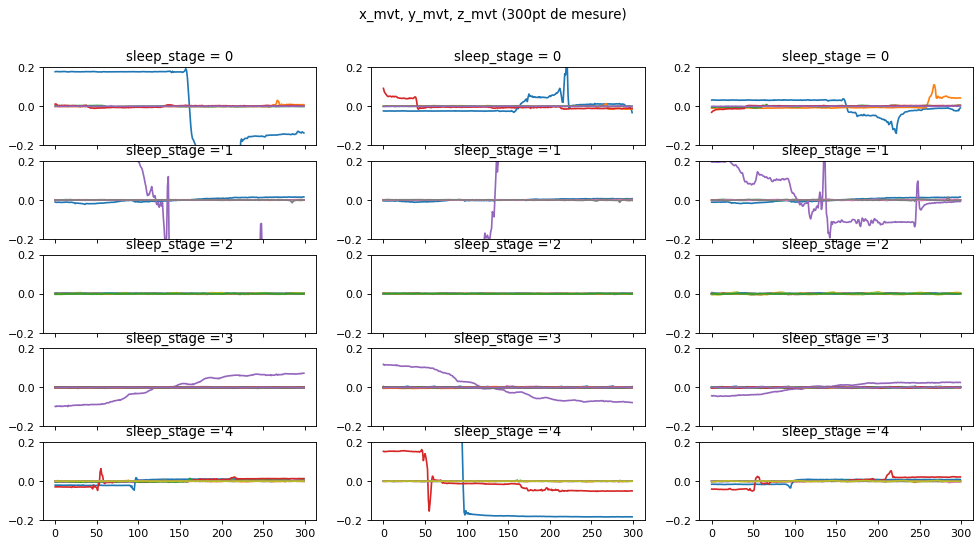

In [846]:
fig, axs = plt.subplots(5,3 , sharex=True, figsize=(15,5*1.5))
fig.suptitle("x_mvt, y_mvt, z_mvt (300pt de mesure)")

for i in range(5):
  for j in range(3):
    axs[i][j].set_title("sleep_stage = "+str(i))
    axs[i][j].set_ylim([-0.2,0.2])

n = 50
for sample in range(n):
  indice = rd.randint(24688)
  sleep = y['sleep_stage'][indice]
  if sleep == 0:
    axs[0][0].plot(x_mvt[indice] - np.mean(x_mvt[indice]))
    axs[0][1].plot(y_mvt[indice] - np.mean(y_mvt[indice]))
    axs[0][2].plot(z_mvt[indice] - np.mean(z_mvt[indice]))

  elif sleep == 1:
    axs[1][0].plot(x_mvt[indice] - np.mean(x_mvt[indice]))
    axs[1][1].plot(y_mvt[indice] - np.mean(y_mvt[indice]))
    axs[1][2].plot(z_mvt[indice] - np.mean(z_mvt[indice]))

  elif sleep == 2:
    axs[2][0].plot(x_mvt[indice] - np.mean(x_mvt[indice]))
    axs[2][1].plot(y_mvt[indice] - np.mean(y_mvt[indice]))
    axs[2][2].plot(z_mvt[indice] - np.mean(z_mvt[indice]))

  elif sleep == 3:
    axs[3][0].plot(x_mvt[indice] - np.mean(x_mvt[indice]))
    axs[3][1].plot(y_mvt[indice] - np.mean(y_mvt[indice]))
    axs[3][2].plot(z_mvt[indice] - np.mean(z_mvt[indice]))

  elif sleep == 4:
    axs[4][0].plot(x_mvt[indice]- np.mean(x_mvt[indice]))
    axs[4][1].plot(y_mvt[indice]- np.mean(y_mvt[indice]))
    axs[4][2].plot(z_mvt[indice]- np.mean(z_mvt[indice]))

In [ ]:
#@title code for boxplot on REM
fig, axs = plt.subplots(1,3, sharex=True, figsize=(15,8))
fig.suptitle("standard deviation")  

x_mvt_std, y_mvt_std, z_mvt_std = [[], [], [], [], []], [[], [], [], [], []], [[], [], [], [], []]
n = 12344
for sample in range(0,n,2):
  indice = sample #rd.randint(24688)
  sleep = y['sleep_stage'][indice]
  x_signal = abs(x_mvt[indice] - np.mean(x_mvt[indice]))
  y_signal = abs(y_mvt[indice] - np.mean(y_mvt[indice]))
  z_signal = abs(z_mvt[indice] - np.mean(z_mvt[indice]))
  std_x = np.mean(x_signal)
  std_y = np.mean(y_signal)
  std_z = np.mean(z_signal)
  if sleep == 0:
    x_mvt_std[0].append(std_x)
    y_mvt_std[0].append(std_y)
    z_mvt_std[0].append(std_z)
  elif sleep == 1:
    x_mvt_std[1].append(std_x)
    y_mvt_std[1].append(std_y)
    z_mvt_std[1].append(std_z)
  elif sleep == 2:
    x_mvt_std[2].append(std_x)
    y_mvt_std[2].append(std_y)
    z_mvt_std[2].append(std_z)
  elif sleep == 3:
    x_mvt_std[3].append(std_x)
    y_mvt_std[3].append(std_y)
    z_mvt_std[3].append(std_z)
  elif sleep == 4:
    x_mvt_std[4].append(std_x)
    y_mvt_std[4].append(std_y)
    z_mvt_std[4].append(std_z)

axs[0].boxplot(x_mvt_std)
axs[1].boxplot(y_mvt_std)
axs[2].boxplot(z_mvt_std)
'''
axs[0][0].set_title("x_mvt_std")
axs[1][0].set_title("y_mvt_std")
axs[2][0].set_title("z_mvt_std")
'''

On peut donc supposer que l'amplitude, la vitesse, ansi que l'aléatoire des mouvements sont significatifs de la classe de sommeil dans laquelle le témoin se trouve. Face à ces constats, nous proposons donc analyse temporelle, fréquencielle et énergétique des signaux, ce qui permettra de quantifier l'amplitude des mouvements ainsi que la vitesse de ceux-ci. Nous calculons pour chacunne des variables de position : 

Temporel:

1. Écart type de la position 
2. Écart type de la variation de position
3. Amplitude moyenne de la position
4. Amplitude moyenne de la variation de position
5. Énergie du signal 
6. Entropie du signal ApEnt et mesure fractale du signal

Fréquenciel:

8. Valeur maximale de la transformée de Fourier
9. Fréquence à laquelle ce maximum est atteint
10. Energie du signal par la densité spectrale de puissance
11. Puissance moyenne du signal

Cela représente 33 features au total. 

In [623]:
#function qui crée le df correspondant au mouvement moyen des yeux

from scipy.ndimage.interpolation import shift


def creat_mvt_df(mvt_list, indices):
    df_eye_std = pd.DataFrame(columns = ['eye_time_std_x','eye_time_std_y','eye_time_std_z',
                                        'eye_time_varstd_x','eye_time_varstd_y','eye_time_varstd_z',
                                        'eye_time_ampavg_x','eye_time_ampavg_y','eye_time_ampavg_z',
                                        'eye_time_varampavg_x','eye_time_varampavg_y','eye_time_varampavg_z',
                                        'eye_time_ene_x','eye_time_ene_y','eye_time_ene_z',
                                        'eye_time_appent_x','eye_time_appent_y','eye_time_appent_z',
                                        'eye_time_detfluc_x','eye_time_detfluc_y','eye_time_detfluc_z',                                             
                                        'eye_fft_max_x','eye_fft_max_y','eye_fft_max_z',
                                        'eye_fft_argmax_x','eye_fft_argmax_y','eye_fft_argmax_z',
                                        'eye_fft_ene_x','eye_fft_ene_y','eye_fft_ene_z',
                                        'eye_fft_powavg_x','eye_fft_powavg_y','eye_fft_powavg_z'])

    frequency = np.fft.rfftfreq(len(mvt_list[0][0]))[1:]

    for i in range(len(mvt_list[0])):
        eye_time_std = []
        eye_time_varstd = []
        eye_time_ampavg = []
        eye_time_varampavg = []
        eye_time_ene = []
        eye_time_appent = []
        eye_time_detfluc = []
        eye_fft_max = []
        eye_fft_argmax = []
        eye_fft_ene = []
        eye_fft_powavg = []
        
        for j in range(3):
            signal = mvt_list[j][i]
            powerspectrum = np.square(np.abs(np.fft.rfft(signal)))#[1:]
            
            eye_time_std.append(np.std(signal))
            eye_time_varstd.append(np.std(signal-shift(signal,1)))
            eye_time_ampavg.append(np.average(np.abs(signal)))
            eye_time_varampavg.append(np.average(np.abs(signal-shift(signal,1))))
            eye_time_ene.append(np.square(signal-np.mean(signal)).sum())
            eye_time_appent.append(app_entropy(mvt_list[j][i]))
            eye_time_detfluc.append(detrended_fluctuation(mvt_list[j][i]))
                        
            eye_fft_max.append(max(powerspectrum))
            eye_fft_argmax.append(frequency[np.where(powerspectrum == max(powerspectrum))])
            eye_fft_ene.append(np.sum(powerspectrum))                
            eye_fft_powavg.append(np.mean(powerspectrum))
            
        df_eye_std.loc[i] = np.array([eye_time_std[0],eye_time_std[1],eye_time_std[2],
                                                eye_time_varstd[0],eye_time_varstd[1],eye_time_varstd[2],
                                                eye_time_ampavg[0],eye_time_ampavg[1],eye_time_ampavg[2],
                                                eye_time_varampavg[0],eye_time_varampavg[1],eye_time_varampavg[2],
                                                eye_time_ene[0],eye_time_ene[1],eye_time_ene[2],
                                                eye_time_appent[0],eye_time_appent[1],eye_time_appent[2],
                                                eye_time_detfluc[0],eye_time_detfluc[1],eye_time_detfluc[2],                                               
                                                eye_fft_max[0],eye_fft_max[1],eye_fft_max[2],
                                                eye_fft_argmax[0],eye_fft_argmax[1],eye_fft_argmax[2],
                                                eye_fft_ene[0],eye_fft_ene[1],eye_fft_ene[2],
                                                eye_fft_powavg[0],eye_fft_powavg[1],eye_fft_powavg[2]])


        if i%50==0: print(i/len(mvt_list[0]))
    return df_eye_std

In [625]:
#df_mvt_std= creat_mvt_df([x_mvt, y_mvt, z_mvt], index_absolute)
df_mvt_std.to_csv("df_mvt_std-10.txt")
#df_mvt_std = pd.read_csv("/content/df_mvt_std.txt")

In [ ]:
df_mvt_std_kaggle= creat_mvt_df([x_mvt_kaggle, y_mvt_kaggle, z_mvt_kaggle], index_absolute_kaggle)
df_mvt_std.to_csv("df_mvt_std_kaggle-10.txt")
#df_mvt_std = pd.read_csv("/content/df_mvt_std.txt")

## Features extraites des pouls

Pour le pouls, nous avons choisis différentes features tirées de l'analyse fréquencielle du signal.

Temporel : 

1. Fréquence cardiaque. Pour extraire la fréquence cardiaque, nous utilisons la bibliotheque heartpy dont la fonction de calcul du BPM donne de bons résultats malgré le bruit présent sur les signaux. Dans le cas ou cette fonction ne peut pas donner de résultat, nous utilisons la médiane de la série comme valeure (utilisation de SimpleImputer)

2. Variation de la fréquence cardiaque RMSSD. Cette mesure, également issue de la bibliothèque heartpy, donne une information sur la variation de la pulsation cardiaque. Pour se faire, la distance entre deux pics est prise en moyenne quadratique.

$$RMSSD=\sqrt{\frac{1}{n-2}\sum_0^{n-2}(R_{n+1}-R_n)^2}$$

3. Mesures d'entropies ApEn SamEn DisEn et complexité de Lempel-Ziv (définies plus tôt). Ces mesures permettent de caractériser l'irrégularité dans les signaux, irrégularité qui présente une correlation interessante avec les phases de sommeil.

4. Amplitude moyenne, variance absolue moyenne et énergie

Fréquentiel : 

1. Valeure moyenne de la densité spectrale de puissance 
2. Énergie du signal en passant par la densite spectrale de puissance

Au total, cela représente donc 6 features.

In [41]:
#pip install heartpy

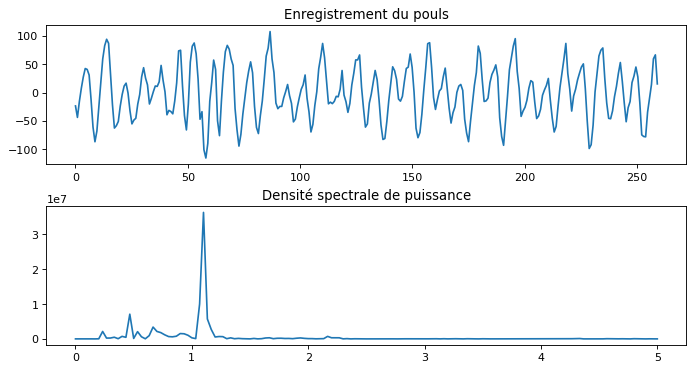

In [835]:
import heartpy as hp
#@title Tracé du fondamental et de la densité spectrale pour un signal pris au hasard
i = rd.randint(24688)
x = pulse[i]

working_data, measures = hp.process(x, 10.0)

fs = 10
T = 30.0 #30 seconds signal
nsamples = int(T * fs)
t = np.linspace(0, T, nsamples, endpoint=False)

#density spectrale de puissance
fourier_transform = np.fft.rfft(x)
abs_fourier_transform = np.abs(fourier_transform)
power_spectrum = np.square(abs_fourier_transform)
frequency = np.fft.rfftfreq(len(x)) * fs #np.linspace(0, fs/2, len(power_spectrum))

#check sinusoide
f_max = frequency[np.where(power_spectrum == np.max(power_spectrum))[0][0]]
N = 300 # Nombre de points enregistres
t = np.linspace(0, 259, 300) # Grille d'echantillonnage
sinusoide = np.sin(2.*np.pi * t * f_max/fs)*max(x)
sinusoide2 = np.sin(2.*np.pi * t * measures['bpm']/(fs*60))*max(x)
plt.rcParams['figure.dpi'] = 80 # default for me was 75
#plot
fig, ax = plt.subplots(2,1,figsize=(40,4))
ax[0].plot(t, x)
ax[0].set_title('Enregistrement du pouls')
ax[1].plot(frequency, power_spectrum)
ax[1].set_title('Densité spectrale de puissance')
plt.subplots_adjust(left=0.4, right=0.6, top=1, bottom=0,hspace=0.3)

In [88]:
from entropy import *

def create_pulse_df(pulse_data, indices):

    df_pulse = pd.DataFrame(columns = ['pulse','hrv','app_ent','lzi_ent','sam_ent','dis_ent','avvar', 'avamp','energie','fft_avg','fft_ene'])

    for i in range(len(pulse_data)):
        x = pulse_data[i]

        try:
            working_data, measures = hp.process(x, 10.0)
            bpm = measures['bpm']
            rmssd = measures['rmssd']
        except:
            bpm = float("NaN")
            rmssd = float("NaN")
        app_ent= app_entropy(x)
        lzi_ent= lziv_complexity(x)
        sam_ent= sample_entropy(x)
        dis_ent= perm_entropy(x)
        avvar=np.average(np.abs(x-shift(x,1)))
        avamp=np.average(np.abs(x-np.mean(x)))
        energie=np.square(x-np.mean(x)).sum()
        powerspectrum = np.square(np.abs(np.fft.rfft(signal)))
        fft_avg=np.mean(powerspectrum)
        fft_ene=np.sum(powerspectrum)
    
        df_pulse.loc[indices[i]] = [bpm, rmssd,app_ent,lzi_ent,sam_ent,dis_ent,avvar, avamp,energie,fft_avg,fft_ene]
  
    return df_pulse

In [456]:
df_pulse = create_pulse_df(pulse, index_absolute)
df_pulse.to_csv("df_pulse-10.txt")

In [ ]:
df_pulse_kaggle = create_pulse_df2(pulse_kaggle, index_absolute)
df_pulse_kaggle.to_csv("df_pulse_kaggle-10.txt")

# Utilisation de Random Forest pour classifier

Nous avons testé les modèles suivants en effectuant un entrainement simple sans optimisation particulière. Les modèles testés sont les suivants, ainsi que les F1-score recolté

- SVC, 0.208
- KNN 5 clases, 0.636
- MLPClassifier, 0.323 
- DecisionTree, 0.650
- RandomForest, 0.739
- Naive Bayes (GaussianNB), 0.093

Les résultats nous ont conduit à selectionner le RandomForest

## Description de l'algorithme Random Forest

RandomForest est une technique d'apprentissage basée sur la construction d'arbres de décision. Un grand nombre d'arbre décisionnel est construit, puis la meilleure prédiction est sélectionnée.

Chaque arbre est construit en utilisant des techniques connues de construction d'arbres décisionnels et à l'aide 
- d'un échantillon d'observation de taille donnée tiré aléatoirement avec remise parmi les observations d'entrainement
- d'un échantillon de caractéristiques de taille plus petite que la racine du nombre totale de caractéristiques, elles aussi tirées aléatoirement parmi les caractéristiques fournies

Nous utiliserons le modèle RandomForest implémenté dans la bibliothèque $\texttt{sklearn}$. Dans ce module, les paramètres tels que le nombre d'arbre, le nombre minimal d'observation par feuilles ou par noeuds, la profondeur maximale de l'arbre, le mode de construction de chaque abre, peuvent êtres réglés. Aussi nous rechercherons les paramètres idéaux pour notre modèle à l'aide d'une $\textit{grid search}$.

## Post-processing des features

Lorsque certaines mesures (notamment le pouls) ne peuvent être calculées, un NaN est inséré à la place dans les dataset. Ici nous allons donc utiliser un imputer pour remplacer les valeures NaN par la médiane de la série. En effet, lorsque l'on ne peut pas estimer une mesure, retenir la médiane permet de réduire le risque d'être trop éloigné de la vraie valeur alors inconnue.

Nous avons également tenté de procéder à de l'aglomération de caractéristique par les méthodes PCA et Feature Agglomeration du module sklearn, mais sans grand impacts sur les résultats.

In [ ]:
## --- CONCATENATION DES CARACT ---

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

df_pulse = pd.read_csv("df_pulse-10.txt").drop(['Unnamed: 0'],axis=1)
df_mvt_std = pd.read_csv("df_mvt_std-10.txt").drop(['Unnamed: 0'],axis=1)
df_eeg_entropy = pd.read_csv('df_egg_entropy-2.txt').drop(['Unnamed: 0'],axis=1)
df_features_power = pd.read_csv("df_features_power-2.txt").drop(['Unnamed: 0'],axis=1)
df_eegs_mmd_esis = pd.read_csv("df_eegs_mmd_esis.txt").drop(['Unnamed: 0'],axis=1)

#col_drop = to_drop
col_drop = [ ]
#                 'eeg1_alpha_power', 'eeg1_beta_power', 'eeg1_delta_power', 'eeg1_theta_power', 
#                 'eeg2_delta_power', 'eeg2_theta_power', 'eeg2_alpha_power', 'eeg2_beta_power',
#                 'eeg3_alpha_power', 'eeg3_beta_power', 'eeg3_delta_power', 'eeg3_theta_power', 
#                 'eeg4_alpha_power', 'eeg4_beta_power', 'eeg4_delta_power', 'eeg4_theta_power',
#                 'eeg5_alpha_power', 'eeg5_beta_power', 'eeg5_delta_power', 'eeg5_theta_power',
#                 'eeg6_alpha_power', 'eeg6_beta_power', 'eeg6_delta_power', 'eeg6_theta_power',
#                 'eeg7_delta_power', 'eeg7_theta_power', 'eeg7_alpha_power', 'eeg7_beta_power',
#                 'energie_x','energie_y','energie_z',
#                 'pos_avamp_x','pos_avamp_y','pos_avamp_z'
#             ]


X=df_pulse.join(df_mvt_std).join(df_eeg_entropy).join(df_features_power).join(df_eegs_mmd_esis).drop(columns=col_drop)
X

In [985]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp = imp.fit(X)
X_imp = pd.DataFrame(imp.transform(X),index=X.index, columns=X.columns)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration

feat_red = FeatureAgglomeration(n_clusters=50)
feat_red.fit(X_imp,y)

corrMatrix = pd.DataFrame(feat_red.transform(X_imp)).join(y).corr()
plt.figure(figsize = (13,10))
sn.heatmap(abs(corrMatrix), annot=False)#,vmin=0, vmax=1)

X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(feat_red.transform(X_imp)), y, test_size=0.4, random_state=42)

## Sélection des features

Face au grand nombre de features et à la faible significativité de celles-ci, nous avons entrainé un premier modèle avec l'entièreté des caractéristiques, puis avons sélectionné celles qui avaient le plus d'importance dans le modèle. Nous avons également veillé à ce que les features ainsi selectionnées avaient une variance suffisante pour être justement exploitées.

Nous utilisons pour cela la methode 'feature-importances' du modèle RandomForest entrainé, et sélectionnons les caractéristiques ayant une importance supérieure à 0.005.

In [986]:
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.15)#, random_state=42)

class_weights= y_train['sleep_stage'].value_counts(normalize=True).reset_index().to_dict()['sleep_stage']
clf_RF_fs = RandomForestClassifier(n_estimators = 100, bootstrap = True, class_weight=class_weights,
                               max_samples = 0.7,min_samples_leaf=1,criterion='entropy')
clf_RF_fs.fit(X_train, y_train['sleep_stage'])
y_train_pred_RF = clf_RF_fs.predict(X_train)
y_test_pred_RF = clf_RF_fs.predict(X_test)


print('Train prior to feature removal : ' + f1_score(y_train, y_train_pred_RF, average='weighted').astype(str))
print('Test prior to feature removal : ' + f1_score(y_test, y_test_pred_RF, average='weighted').astype(str))
print(confusion_matrix(y_test, y_test_pred_RF))

Train prior to feature removal : 0.9989037180994466
Test prior to feature removal : 0.7729378922075391
[[ 481   10   36    1   14]
 [  62   47  106    3   42]
 [  27   12 1206   86   72]
 [  26    1   88  659    1]
 [  34   11  141   18  520]]


In [987]:
importance = clf_RF_fs.feature_importances_
importance = pd.DataFrame(importance, index=X_imp.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in clf_RF_fs.estimators_], axis=0)

#print(importance.sort_values(by=['Importance']).to_string())
print('Features to remove :')
print(importance[importance['Importance']<0.005].index)
to_drop = importance[importance['Importance']<0.005].index

Features to remove :
Index(['hrv', 'lzi_ent', 'avamp', 'energie', 'fft_avg', 'fft_ene',
       'eye_time_varstd_x', 'eye_time_ampavg_x', 'eye_time_detfluc_x',
       'eye_fft_max_x', 'eye_fft_argmax_x', 'eye_fft_argmax_y',
       'eye_fft_argmax_z', 'eye_fft_ene_x', 'eye_fft_powavg_x', 'eeg3_app_ent',
       'eeg7_app_ent', 'eeg7_delta_power', 'eeg7_theta_power',
       'eeg7_alpha_power', 'eeg1_beta_mmd', 'eeg2_delta_esis',
       'eeg2_theta_mmd', 'eeg2_alpha_mmd', 'eeg2_beta_mmd', 'eeg3_delta_mmd',
       'eeg3_delta_esis', 'eeg3_theta_mmd', 'eeg3_alpha_mmd', 'eeg3_beta_mmd',
       'eeg4_delta_mmd', 'eeg4_delta_esis', 'eeg4_theta_mmd', 'eeg4_alpha_mmd',
       'eeg4_beta_mmd', 'eeg5_beta_mmd', 'eeg6_theta_mmd', 'eeg6_alpha_mmd',
       'eeg6_beta_mmd', 'eeg7_delta_mmd', 'eeg7_delta_esis', 'eeg7_theta_mmd',
       'eeg7_theta_esis', 'eeg7_alpha_mmd', 'eeg7_beta_mmd'],
      dtype='object')


In [988]:
col_drop = to_drop
X=df_pulse.join(df_mvt_std).join(df_eeg_entropy).join(df_features_power).join(df_eegs_mmd_esis).drop(columns=col_drop)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X)
X_imp = pd.DataFrame(imp.transform(X),index=X.index, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.15)#, random_state=42)

class_weights= y_train['sleep_stage'].value_counts(normalize=True).reset_index().to_dict()['sleep_stage']
clf_RF_fs = RandomForestClassifier(n_estimators = 100, bootstrap = True, class_weight=class_weights,
                               max_samples = 0.7,min_samples_leaf=1,criterion='entropy')
clf_RF_fs.fit(X_train, y_train['sleep_stage'])
y_train_pred_RF = clf_RF_fs.predict(X_train)
y_test_pred_RF = clf_RF_fs.predict(X_test)


print('Train prior to feature removal : ' + f1_score(y_train, y_train_pred_RF, average='weighted').astype(str))
print('Test prior to feature removal : ' + f1_score(y_test, y_test_pred_RF, average='weighted').astype(str))
print(confusion_matrix(y_test, y_test_pred_RF))

Train prior to feature removal : 0.9984262647079574
Test prior to feature removal : 0.7920467187731517
[[ 473    8   37    3   14]
 [  53   46   84    5   41]
 [  32   10 1275   52   71]
 [  12    3   86  667    2]
 [  29   11  166    9  515]]


## Grid search et cross-validation

Nous commençons par effectuer une grid-search. Nous découpons le dataset en un échantillon d'entrainement et un échentillon de test, et nous effectuons la grid-search avec les paramètres suivants :

In [819]:
parameters = {
        'max_samples':[0.3, 0.5, 0.7],
        'min_samples_leaf':[1,3,5], 
        'max_features':[3,5,10], 
        'max_depth':[None,5,10],
        'criterion': ['gini', 'entropy'],
        'n_estimators':[100], 
        'bootstrap':[True]
}
print(parameters)

{'max_samples': [0.3, 0.5, 0.7], 'min_samples_leaf': [1, 3, 5], 'max_features': [1, 3, 5], 'max_depth': [None, 5, 10], 'criterion': ['gini', 'entropy'], 'n_estimators': [100], 'bootstrap': [True]}


In [820]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.15)#, random_state=42)
class_weights= y_train['sleep_stage'].value_counts(normalize=True).reset_index().to_dict()['sleep_stage']

rf = RandomForestClassifier(class_weight=class_weights)
rf = GridSearchCV(rf, param_grid=parameters, scoring='f1_weighted', cv=5, return_train_score=True)
rf.fit(X_train, y_train['sleep_stage'])
y_train_pred_RF = rf.predict(X_train)
y_test_pred_RF = rf.predict(X_test)

print('Train: ' + f1_score(y_train, y_train_pred_RF, average='weighted').astype(str))
print('Test: ' + f1_score(y_test, y_test_pred_RF, average='weighted').astype(str))
print(confusion_matrix(y_test, y_test_pred_RF))

Train: 0.9983795468225298
Test: 0.7621736894333069
[[ 462   13   39    2   26]
 [  58   53  106    5   40]
 [  47   13 1209   54   60]
 [  23    2  119  626    3]
 [  30   15  165   18  516]]


Les paramètres retenus sont les suivants : 

In [823]:
rf.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 5,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'n_estimators': 100}

Enfin nous effectons une cross validation à 10 repliements pour valider les perfomances du modèle. Les résultats sont les suivants :

In [989]:
class_weights= y['sleep_stage'].value_counts(normalize=True).reset_index().to_dict()['sleep_stage']
clf_RF = RandomForestClassifier(n_estimators = 1000, bootstrap = True, class_weight=class_weights,
                               max_samples = 0.7,min_samples_leaf=1,criterion='gini')
cv = cross_val_score(clf_RF,X_imp,y['sleep_stage'],cv=10)
print ("Accuracy using RF with 10 cross validation : {}%".format(round(np.mean(cv)*100,2)))
print('Scores of folds:')
print(cv)

Accuracy using RF with 10 cross validation : 65.19%
Scores of folds:
[0.58930741 0.6618064  0.73390036 0.65937627 0.6581612  0.61846902
 0.69380316 0.67557716 0.56199352 0.66693679]


In [ ]:
clf_RF = RandomForestClassifier(n_estimators = 100, bootstrap = True, class_weight=class_weights,
                               max_samples = 0.7,min_samples_leaf=1,max_features=10,criterion='gini')
clf_RF.fit(X_imp, y['sleep_stage'])

# Conclusion 

Le modèle proposé permet de prédire la phase de sommeil avec une précision moyenne de 65% (F1-score).

Pour améliorer ce score, on pourrait explorer les pistes suivantes :

- Retraiter les enregistrements pour tenter d'en extraire le bruit, ou ignorer la mesure lorsque l'enregistrement est abérant (par exemple si l'EEG présente des sauts, si le pulse est trop bruité, etc). Le modèle ne serait alors pas trompé lors de l'entrainement.
- Affiner les caractéristiques, par exemple pour mieux détecter les motifs spécifiques sur les EEG (les K-complexes par exemple)

In [ ]:
#----------------------
#----------------------
# Submission to kaggle
#----------------------
#----------------------

In [75]:
hdFileName = 'X_test.h5'
modeType   = 'r'
hf_kaggle = h5py.File(hdFileName, modeType)

In [76]:
#electroencephalogrammes
eeg1_kaggle = hf_kaggle['eeg_1']
eeg2_kaggle = hf_kaggle['eeg_2']
eeg3_kaggle = hf_kaggle['eeg_3']
eeg4_kaggle = hf_kaggle['eeg_4']
eeg5_kaggle = hf_kaggle['eeg_5']
eeg6_kaggle = hf_kaggle['eeg_6']
eeg7_kaggle = hf_kaggle['eeg_7']

#pouls
pulse_kaggle = hf_kaggle['pulse']

#des indices (why not)
index_kaggle = hf_kaggle['index']
index_absolute_kaggle = hf_kaggle['index_absolute']
index_window_kaggle = hf_kaggle['index_window']

#mouvement des yeux
x_mvt_kaggle, y_mvt_kaggle, z_mvt_kaggle = hf_kaggle['x'], hf_kaggle['y'], hf_kaggle['z']

In [ ]:
#Rapple prend 40min à calculer
#penser à executer la cellule "Definition de bandpower" avant
df_features_power_kaggle = create_power_df([eeg1_kaggle, eeg2_kaggle, eeg3_kaggle, eeg4_kaggle, eeg5_kaggle, eeg6_kaggle, eeg7_kaggle], index_absolute_kaggle)
df_pulse_kaggle = create_pulse_df(pulse_kaggle, index_absolute_kaggle) #kaggle data
df_mmd_esis_kaggle = gen_mmd_esis([eeg1_kaggle, eeg2_kaggle, eeg3_kaggle, eeg4_kaggle, eeg5_kaggle, eeg6_kaggle, eeg7_kaggle])
df_mvt_std_kaggle = creat_mvt_df([x_mvt_kaggle, y_mvt_kaggle, z_mvt_kaggle], index_absolute_kaggle)
df_features_power_kaggle.to_csv('/content/df_features_power_kaggle.txt')
df_mvt_std_kaggle.to_csv('df_mvt_std_kaggle-2.txt')
df_mmd_esis_kaggle.to_csv('df_mmd_esis_kaggle.txt')
df_pulse_kaggle.to_csv('df_pulse_kaggle-3.txt')

In [ ]:
#col_drop = ["eeg1_delta_power", "eeg1_theta_power", "eeg1_alpha_power", "eeg1_beta_power",\
#            "eeg2_delta_power", "eeg2_theta_power", "eeg2_alpha_power", "eeg2_beta_power"]
df_features_power_kaggle= pd.read_csv('df_features_power_kaggle-2.txt').drop(['Unnamed: 0'],axis=1)
df_mvt_std_kaggle= pd.read_csv('df_mvt_std_kaggle-10.txt').drop(['Unnamed: 0'],axis=1)
df_mmd_esis_kaggle= pd.read_csv('df_mmd_esis_kaggle.txt').drop(['Unnamed: 0'],axis=1)
df_pulse_kaggle= pd.read_csv('df_pulse_kaggle-3.txt').drop(['Unnamed: 0'],axis=1)
#add eye mvt and pulse data
col_drop = to_drop
X_test_kaggle =df_pulse_kaggle.join(df_pulse2_kaggle).join(df_mvt_std_kaggle).join(df_eeg_entropy_res).join(df_features_power_kaggle).join(df_mmd_esis_kaggle).drop(columns=col_drop)

# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp = imp.fit(X_test_kaggle)
X_test_kaggle = pd.DataFrame(imp.transform(X_test_kaggle),index=X_test_kaggle.index, columns=X_test_kaggle.columns)

X_test_kaggle

In [992]:
y_pred_kaggle = clf_RF.predict(X_test_kaggle)

In [993]:
submission = pd.DataFrame({'index' : index_absolute_kaggle, 'sleep_stage' : y_pred_kaggle}).set_index('index')

In [994]:
submission.to_csv('submission.csv')

In [ ]:
!kaggle competitions submit -c dreem-2-sleep-classification-challenge-2020 -f submission.csv -m "Sub"

In [ ]:
df_mvt_std_kaggle